Columns in DataFrame:
['filename', 'back_croup-x', 'back_croup-y', 'back_left_hip-x', 'back_left_hip-y', 'back_left_knee-x', 'back_left_knee-y', 'back_left_paw-x', 'back_left_paw-y', 'back_left_wrist-x', 'back_left_wrist-y', 'back_midpoint-x', 'back_midpoint-y', 'back_right_hip-x', 'back_right_hip-y', 'back_right_knee-x', 'back_right_knee-y', 'back_right_paw-x', 'back_right_paw-y', 'back_right_wrist-x', 'back_right_wrist-y', 'back_withers-x', 'back_withers-y', 'chest-x', 'chest-y', 'front_left_elbow-x', 'front_left_elbow-y', 'front_left_paw-x', 'front_left_paw-y', 'front_left_shoulder-x', 'front_left_shoulder-y', 'front_left_wrist-x', 'front_left_wrist-y', 'front_right_elbow-x', 'front_right_elbow-y', 'front_right_paw-x', 'front_right_paw-y', 'front_right_shoulder-x', 'front_right_shoulder-y', 'front_right_wrist-x', 'front_right_wrist-y', 'head_midpoint-x', 'head_midpoint-y', 'left_ear_base-x', 'left_ear_base-y', 'left_ear_tip-x', 'left_ear_tip-y', 'left_eye-x', 'left_eye-y', 'lower_ja

/Users/jonasmucke/miniconda3/lib/python3.10/site-packages/sklearn/impute/_base.py:558: UserWarning: Skipping features without any observed values: [22 23 24 25 28 29]. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(


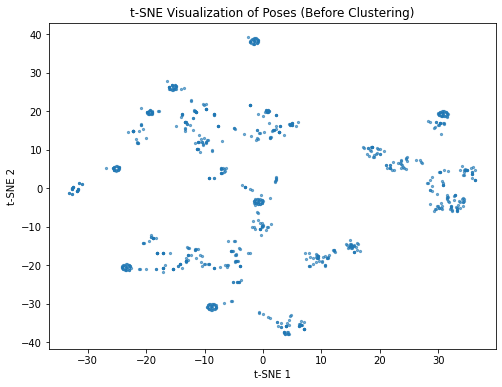

/Users/jonasmucke/miniconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/jonasmucke/miniconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/jonasmucke/miniconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/jonasmucke/miniconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_

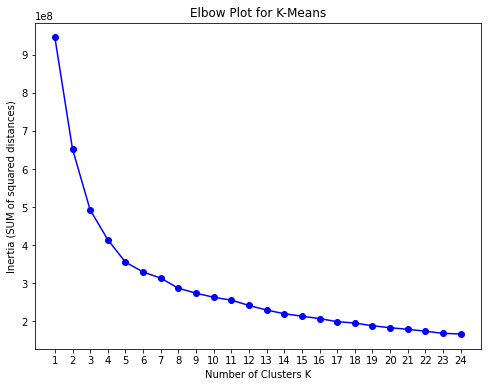

/Users/jonasmucke/miniconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/var/folders/q8/3qtld8c51tq6rsc2lwvp417w0000gn/T/ipykernel_55408/2810675129.py:71: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab20', len(unique_labels))


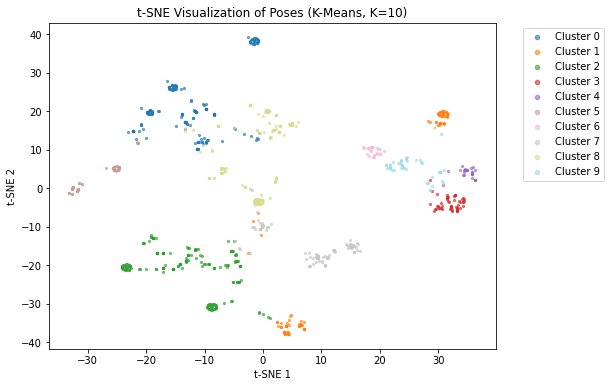


Train set size: 675
cluster
0    0.191111
1    0.102222
2    0.205926
3    0.063704
4    0.031111
5    0.059259
6    0.029630
7    0.108148
8    0.157037
9    0.051852
Name: proportion, dtype: float64

Validation set size: 84
cluster
0    0.190476
1    0.095238
2    0.202381
3    0.059524
4    0.035714
5    0.059524
6    0.035714
7    0.107143
8    0.154762
9    0.059524
Name: proportion, dtype: float64

Test set size: 85
cluster
0    0.200000
1    0.105882
2    0.211765
3    0.070588
4    0.023529
5    0.058824
6    0.023529
7    0.105882
8    0.152941
9    0.047059
Name: proportion, dtype: float64


In [4]:
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# 1. Load the annotations file (change path if needed)
df = pd.read_csv('Rat/top/annotations.csv')

# 1a. Print all column names to confirm
print("Columns in DataFrame:")
print(df.columns.tolist())

# 1b. Build list of columns to drop (filename + any starting with 'bbox_')
drop_cols = []
if 'filename' in df.columns:
    drop_cols.append('filename')
for col in df.columns:
    if col.startswith('bbox_'):
        drop_cols.append(col)

print("\nDropping columns:")
print(drop_cols)

# 1c. Drop those columns
df_filtered = df.drop(columns=drop_cols)

# 2. Extract keypoint data and impute missing values
X_raw = df_filtered.values
imputer = SimpleImputer(strategy='mean')
X = imputer.fit_transform(X_raw)

# 3. t-SNE BEFORE clustering (visualize raw keypoints)
tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(X)

plt.figure(figsize=(8, 6))
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], s=5, alpha=0.6)
plt.title('t-SNE Visualization of Poses (Before Clustering)')
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.show()

# 4. Elbow method: compute inertia for K = 1..15
inertias = []
K_range = range(1, 25)
for k in K_range:
    km = KMeans(n_clusters=k, random_state=42)
    km.fit(X)
    inertias.append(km.inertia_)

plt.figure(figsize=(8, 6))
plt.plot(K_range, inertias, 'bo-')
plt.xticks(K_range)
plt.xlabel('Number of Clusters K')
plt.ylabel('Inertia (SUM of squared distances)')
plt.title('Elbow Plot for K-Means')
plt.show()

# 5. Choose K based on the elbow plot (e.g., K = 8 here as an example)
chosen_k = 10
kmeans = KMeans(n_clusters=chosen_k, random_state=42)
cluster_labels = kmeans.fit_predict(X)
df['cluster'] = cluster_labels

# 6. t-SNE AFTER clustering (color by K-Means cluster)
plt.figure(figsize=(8, 6))
unique_labels = np.unique(cluster_labels)
colors = plt.cm.get_cmap('tab20', len(unique_labels))
for lbl in unique_labels:
    idx = (cluster_labels == lbl)
    plt.scatter(
        X_tsne[idx, 0],
        X_tsne[idx, 1],
        s=5,
        alpha=0.6,
        label=f'Cluster {lbl}',
        color=colors(lbl % 20)
    )
plt.title(f't-SNE Visualization of Poses (K-Means, K={chosen_k})')
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.legend(markerscale=2, bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

# 7. Stratified split into train (80%), val (10%), test (10%) by cluster label
indices = np.arange(len(df))
train_idx, temp_idx, y_train, y_temp = train_test_split(
    indices,
    df['cluster'],
    test_size=0.2,
    stratify=df['cluster'],
    random_state=42
)
val_idx, test_idx, y_val, y_test = train_test_split(
    temp_idx,
    y_temp,
    test_size=0.5,
    stratify=y_temp,
    random_state=42
)

train_df = df.iloc[train_idx].reset_index(drop=True)
val_df   = df.iloc[val_idx].reset_index(drop=True)
test_df  = df.iloc[test_idx].reset_index(drop=True)

print('\nTrain set size:', len(train_df))
print(train_df['cluster'].value_counts(normalize=True).sort_index())

print('\nValidation set size:', len(val_df))
print(val_df['cluster'].value_counts(normalize=True).sort_index())

print('\nTest set size:', len(test_df))
print(test_df['cluster'].value_counts(normalize=True).sort_index())

# 8. (Optional) Save splits to CSV
train_df.to_csv('Rat/top/train_annotations.csv', index=False)
val_df.to_csv('Rat/top/val_annotations.csv', index=False)
test_df.to_csv('Rat/top/test_annotations.csv', index=False)


In [6]:
# … after dropping bbox + filename, imputing, etc. …
X_tsne = TSNE(n_components=2, random_state=42).fit_transform(X)
df['tsne1'] = X_tsne[:, 0]
df['tsne2'] = X_tsne[:, 1]

chosen_k = 10
cluster_labels = KMeans(n_clusters=chosen_k, random_state=42).fit_predict(X)
df['cluster'] = cluster_labels

df.to_csv('Rat/top/annotations_with_clusters.csv', index=False)


/Users/jonasmucke/miniconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [7]:
# Make directories train test val
# Fill directories with frames from images folder based on test_annotations.csv, train_annotations.csv, val_annotations.csv
# First line in these files is 'filename'
import os
import shutil
import pandas as pd

# === Configurable Paths ===
# Folder containing your image frames
image_src_folder = "Rat/top/images"  # ← change this to where your images actually are

# Folder where you want to place split subfolders
dest_base = "Rat/top/"   # ← will create train/, val/, test/ under here

# CSV files for each split
csv_files = {
    "train": "Rat/top/train_annotations.csv",
    "val":   "Rat/top/val_annotations.csv",
    "test":  "Rat/top/test_annotations.csv",
}

# === Create directories ===
for split in csv_files:
    split_dir = os.path.join(dest_base, split)
    os.makedirs(split_dir, exist_ok=True)

# === Copy images into their respective split folders ===
for split, csv_file in csv_files.items():
    df = pd.read_csv(csv_file)
    if "filename" not in df.columns:
        raise KeyError(f"'filename' column not found in {csv_file}")
    for fname in df["filename"]:
        src_path = os.path.join(image_src_folder, fname)
        dst_path = os.path.join(dest_base, split, os.path.basename(fname))
        if os.path.exists(src_path):
            shutil.copy(src_path, dst_path)
        else:
            print(f"Warning: Source file not found: {src_path}")

print("Done! Images have been copied into:")
for split in csv_files:
    print(f"  • {os.path.join(dest_base, split)}")


Done! Images have been copied into:
  • Rat/top/train
  • Rat/top/val
  • Rat/top/test


In [8]:
import pandas as pd

def find_always_empty_columns(csv_path):
    df = pd.read_csv(csv_path)
    # Drop non-keypoint or helper columns if you want, e.g. bbox_*
    # df = df.drop(columns=[c for c in df.columns if c.startswith('bbox_')], errors='ignore')

    # Find columns where every value is NaN
    always_empty = [col for col in df.columns if df[col].isna().all()]

    print(f"Always empty columns ({len(always_empty)}):")
    for col in always_empty:
        print("  ", col)

if __name__ == "__main__":
    find_always_empty_columns("Rat/top/annotations.csv")


Always empty columns (6):
   chest-x
   chest-y
   front_left_elbow-x
   front_left_elbow-y
   front_left_shoulder-x
   front_left_shoulder-y


In [13]:
import pandas as pd

def show_non_nan_entries(csv_path, column_name):
    # Load the annotations
    df = pd.read_csv(csv_path)

    # Verify the column exists
    if column_name not in df.columns:
        print(f"Column '{column_name}' not found.")
        return

    # Select non-NaN entries and reset index so they’re numbered 1…N
    non_nan = df[column_name].dropna().reset_index(drop=True)

    if non_nan.empty:
        print(f"No non-NaN entries found in '{column_name}'.")
    else:
        print(f"Non-NaN entries in '{column_name}':")
        for idx, val in non_nan.items():
            # idx goes 0,1,2… so add 1 for human-friendly numbering
            print(f"{idx+1:>3}: {val}")


if __name__ == "__main__":
    csv_path = "Rat/top/annotations.csv"
    column = "front_right_shoulder-x"  # change to the column you want
    show_non_nan_entries(csv_path, column)


Non-NaN entries in 'front_right_shoulder-x':
  1: 1396.33
  2: 1152.25
  3: 1377.08
  4: 1371.55
  5: 1374.26
  6: 1381.92
  7: 592.21
  8: 1374.78
  9: 1221.87
 10: 617.48
 11: 1383.07
 12: 1149.76
 13: 1388.56
 14: 1383.07
 15: 1351.55
 16: 1383.07
 17: 1382.9
 18: 1037.65
 19: 1117.55
 20: 1037.66
 21: 1349.17
